## Introduction to Generative Chatbots  

We’ve discussed how seq2seq models were designed for machine translation, but generating dialog can also be accomplished with seq2seq. Rather than converting input in one language to output in another language, we can convert dialog input into a likely corresponding response.

In fact, the only major difference between the code used for a machine translation program and a generative chatbot is the dataset we use to train our model!

What about the three components of closed-domain systems: intent classification, entity recognition, and response selection? When building an open-domain chatbot, intent classification is much harder and an infinite number of intents are possible. Entity recognition is just ignored in favor of the trained “black box” model.

While closed-domain architecture is focused on response selection from a set of predefined responses, generative architecture allows us to perform unbounded text generation. Instead of selecting full sentences, the open-domain model generates word by word or character by character, allowing for new combinations of language.

In the seq2seq decoding function, the decoder generates several possible output tokens and the one with the highest probability (according to the model) gets selected.

## Generative Chatbots
A generative chatbot is an open-domain chatbot program that generates original combinations of language rather than selecting from pre-defined responses. seq2seq models used for machine translation can be used to build generative chatbots.

Dataset choice with generative chatbots
Choosing the right dataset is a common issue when creating generative chatbots. Common concerns include:

Data source (e.g., Twitter, Slack, customer service conversations, etc.)
Authentic dialog vs. fictional dialog
License of dataset
Biases, bigotry, or rudeness within the dataset
Generative chatbot input format
For generative chatbots using a Keras-based seq2seq model, it is necessary to convert user input into NumPy matrices of one-hot vectors.
```python
# the following function converts 
# user input into a NumPy matrix:
 
def string_to_matrix(user_input):
  tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
  user_input_matrix = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
  for timestep, token in enumerate(tokens):
    if token in input_features_dict:
      user_input_matrix[0, timestep, input_features_dict[token]] = 1.
  return user_input_matrix
```
Generative chatbot unknown word handling
There are several solutions to handling unknown words for generative chatbots including ignoring unknown words, requesting that the user rephrase, or using <UNK> tokens.

Handling context for generative chatbots
Generative chatbot research is currently working to resolve how best to handle chat context and information from previous turns of dialog. Some proposed solutions to this include:

training the model to hang onto some previous number of dialog turns
keeping track of the decoder’s hidden state across dialog turns
personalizing models by including user context during training or adding user context as it is included in the user inputm

## Choosing the Right Dataset  

One of the trickiest challenges in building a deep learning chatbot program is choosing a dataset to use for training.  

Even though the chatbot is more open-domain than other architectures we’ve come across, we still need to consider the context of the training data. Many sources of “open-domain” data which hopefully will capture unbiased, broad human conversation, actually have their own biases which will affect our chatbot. If we use customer service data, Twitter data, or Slack data, we’re setting our potential conversations up in a particular way.  
  
Does it matter to us if our model is trained on “authentic” dialog? If we prefer that the model use complete sentences, then TV and movie scripts could be great resources.
   
Depending on your use case for the chatbot, you may also need to consider the license associated with the dataset.
  
Of course, there are ethical considerations as well here. If our training chat data is biased, bigoted, or rude, then our chatbot will learn to be so too.
  
Once we’ve selected and preprocessed a set of chat data, we can build and train the seq2seq model using the chosen dataset.
  
You may recall a previous lesson on seq2seq models involving a rudimentary machine translation program on the Codecademy platform. Similarly, we will be building a generative chatbot on the platform that won’t be passing any Turing tests. Again, you will have the opportunity to build a far more robust chatbot on your own device by increasing the quantity of chat data used (or changing the source entirely), increasing the size and capacity of the model, and allowing for more training time.
  
## Instructions
1.
For the purposes of this lesson, we’ll be working with the Cornell Movie-Dialogs Corpus to gather fictional conversations from The Princess Bride.

Take a look at the files we have set up:

In pb.txt you can see a bit of the raw dialog data — we’re only drawing a small sample so that the program can run smoothly on the Codecademy platform.
In dataset.py we’re preprocessing the dialog so that it is in the format of response pairs, similar to the machine translation pairs we’ve worked with in the past.
At the bottom of dataset.py, print out dialog_combos to see the response pairs we’ll be using.

In [1]:
import more_itertools as mit

data_path = "resources/pb.txt"

# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  raw_lines = f.read().split('\n')

raw_lines.reverse()
lines = []

for line in raw_lines:
    # split line into parts
    line_split = line.split(' +++$+++ ')
    # append tuple of character and line
    line_num = int(line_split[0][1:])

    current_line = line_split[4].strip()
    # append tuple of line num, character and line
    lines.append((line_num, current_line))
# make sure the lines are in order
lines = sorted(lines, key=lambda x: x[0])

# group lines by scene
by_scene = [list(group) for group in mit.consecutive_groups(lines, lambda x: x[0])]

dialog_only = [[dialog_line[1] for dialog_line in dialog_group] 
                for dialog_group in by_scene]

dialog_combos_nested = [list(map(list, zip(dialog_group, dialog_group[1:]))) for dialog_group in dialog_only]

dialog_combos = [combo for combos in dialog_combos_nested for combo in combos]

# print dialog combos:
print(dialog_combos)


[['You feeling any better?', 'A little bit.'], ['A little bit.', 'Guess what.'], ['Guess what.', 'What?'], ['What?', "Your grandfather's here."], ["Your grandfather's here.", "Mom, can't you tell him that I'm sick?"], ["Mom, can't you tell him that I'm sick?", "You are sick, that's why he's here."], ['I brought you a special present.', 'What is it?'], ['What is it?', 'Open it up.'], ['Open it up.', 'A book?'], ['A book?', "That's right."], ["He's climbing the rope. And he's gaining on us.", 'Inconceivable!'], ['Sorry.', 'Thank you.'], ['Thank you.', 'I do not suppose you could speed things up?'], ['Hello.', "It's you."], ["It's you.", 'True!'], ['True!', "You don't look so good.  You don't smell so good either."], ["You don't look so good.  You don't smell so good either.", 'Perhaps not. I feel fine.'], ['Perhaps not. I feel fine.', 'Yeah?'], ['An hour.', 'Yeah, an hour.'], ['Yeah, an hour.', 'A good hour. Yeah.'], ['Now I think you ought to go to sleep.', 'Okay.'], ['Okay.', 'Okay. Ok

## Setting Up the Bot  

Just as we built a chatbot class to handle the methods for our rule-based and retrieval-based chatbots, we’ll build a chatbot class for our generative chatbot.

Inside, we’ll add a greeting method and a set of exit commands, just like we did for our closed-domain chatbots.

However, in this case, we’ll also import the seq2seq model we’ve built and trained on chat data for you, as well as other information we’ll need to generate a response.

As it happens, many cutting-edge chatbots blend a combination of rule-based, retrieval-based, and generative approaches in order to easily handle some intents using predefined responses and offload other inputs to a natural language generation system.

In [2]:
# first stab

class ChatBot:
  
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")

  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on dialog from The Princess Bride. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    
    self.chat(user_response)
  
  def chat(self, reply):
    while not self.make_exit(reply):
      # change this line below:
      reply = input(self.generate_response(reply))
    
  # define .generate_response():
  def generate_response(self,user_input):
    return("Cool!\n")
  
  
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
      
    return False
  
# instantiate your ChatBot below:
cb = ChatBot()
cb.generate_response('hello')

'Cool!\n'

## Generating Chatbot Responses  

As you may have noticed, a fundamental change from one chatbot architecture to the next is how the method that handles conversation works. In rule-based and retrieval-based systems, this method checks for various user intents that will trigger corresponding responses. In the case of generative chatbots, the seq2seq test function we built for the machine translation will do most of the heavy lifting for us!

For our chatbot we’ve renamed decode_sequence() to .generate_response(). As a reminder, this is where response generation and selection take place:

- The encoder model encodes the user input
- The encoder model generates an embedding (the last hidden state values)
- The embedding is passed from the encoder to the decoder
- The decoder generates an output matrix of possible words and their probabilities
- We use NumPy to help us choose the most probable word (according to our model)
- Our chosen word gets translated back from a NumPy matrix into human language and added to the output sentence

In [3]:

from prep import input_features_dict, target_features_dict, reverse_input_features_dict, reverse_target_features_dict, max_decoder_seq_length, input_docs, target_docs, input_tokens, target_tokens, max_encoder_seq_length
from training_model import decoder_inputs, decoder_lstm, decoder_dense, encoder_input_data, num_decoder_tokens, num_encoder_tokens

from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model
import numpy as np
import re

training_model = load_model('training_model.h5')
###### because we're working with a saved model
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
######
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


class ChatBot:
  
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")

  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on dialog from The Princess Bride. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    
    self.chat(user_response)
  
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply))
    
  # update .generate_response():
  def generate_response(self, user_input):
    states_value = encoder_model.predict(user_input)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    chatbot_response = ''

    stop_condition = False
    while not stop_condition:
      output_tokens, hidden_state, cell_state = decoder_model.predict(
        [target_seq] + states_value)

      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      chatbot_response += " " + sampled_token

      if (sampled_token == '<END>' or len(chatbot_response) > max_decoder_seq_length):
        stop_condition = True

      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.

      states_value = [hidden_state, cell_state]

    return chatbot_response
  
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
      
    return False
  
chatty_mcchatface = ChatBot()
# call .generate_response():
chatty_mcchatface.generate_response('hello')




NameError: name 'encoder_model' is not defined

## Handling User Input
Hmm… why can’t our chatbot chat? Right now our .generate_response() method only works with preprocessed data that’s been converted into a NumPy matrix of one-hot vectors. That won’t do for our chatbot; we don’t just want to use test data for our output. We want the .generate_response() method to accept new user input.

Luckily, we can address this by building a method that translates user input into a NumPy matrix. Then we can call that method inside .generate_response() on our user input.

We said it before, and we’ll say it again: we’re adding deep learning in now, so running the code may take a bit more time again.

In [6]:
import numpy as np
import re
from seq2seq import encoder_model, decoder_model, num_decoder_tokens, num_encoder_tokens, input_features_dict, target_features_dict, reverse_target_features_dict, max_decoder_seq_length, max_encoder_seq_length

class ChatBot:
  
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")

  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on dialog from The Princess Bride. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    
    self.chat(user_response)
  
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply))
    
  # define .string_to_matrix() below:
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      # add an if clause to handle user input:
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    states_value = encoder_model.predict(input_matrix)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    chatbot_response = ''

    stop_condition = False
    while not stop_condition:
      output_tokens, hidden_state, cell_state = decoder_model.predict(
        [target_seq] + states_value)

      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      chatbot_response += " " + sampled_token
      
      if (sampled_token == '<END>' or len(chatbot_response) > max_decoder_seq_length):
        stop_condition = True
        
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      
      states_value = [hidden_state, cell_state]
      
    return chatbot_response
  
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
      
    return False
  
chatty_mcchatface = ChatBot()
# call .generate_response():
response = chatty_mcchatface.generate_response("Hello, there!")
print(response)



ModuleNotFoundError: No module named 'seq2seq'

## Review  

Hooray! While our chatbot is far from perfect, it does produce innovative babble, allowing us to create a truly open-domain conversation. Just like with a machine translation model, we want to accommodate new sentence structures and creativity, something we can do with a generative model for our chatbot.
  
  
Of course, even with a better trained model, there are some issues that we need to consider.
  
First, there are ethical considerations that are much harder to discern and track when working with deep learning models. It’s very easy to accidentally train a model to reproduce latent biases within the training data.
  
We’re also making a pretty big assumption right now in our chatbot architecture: the chatbot responses only depend on the previous turn of user input. The seq2seq model we have here won’t account for any previous dialog. For example, our chatbot has no way to handle a simple back-and-forth like this:

```python
User: “Do you have any siblings?”

Chatbot: “Yes, I do”

User: “How many?”

Chatbot: 🤯
```

In addition to topics that have been previously covered, the entire context of the chat is missing. Our chatbot doesn’t know anything about the user, their likes, their dislikes, etc.

As it happens, handling context and previously covered topics is an active area of research in NLP. Some proposed solutions include:

training the model to hang onto some previous number of dialog turns
keeping track of the decoder’s hidden state across dialog turns
personalizing models by including user context during training or adding user context as it is included in the user input

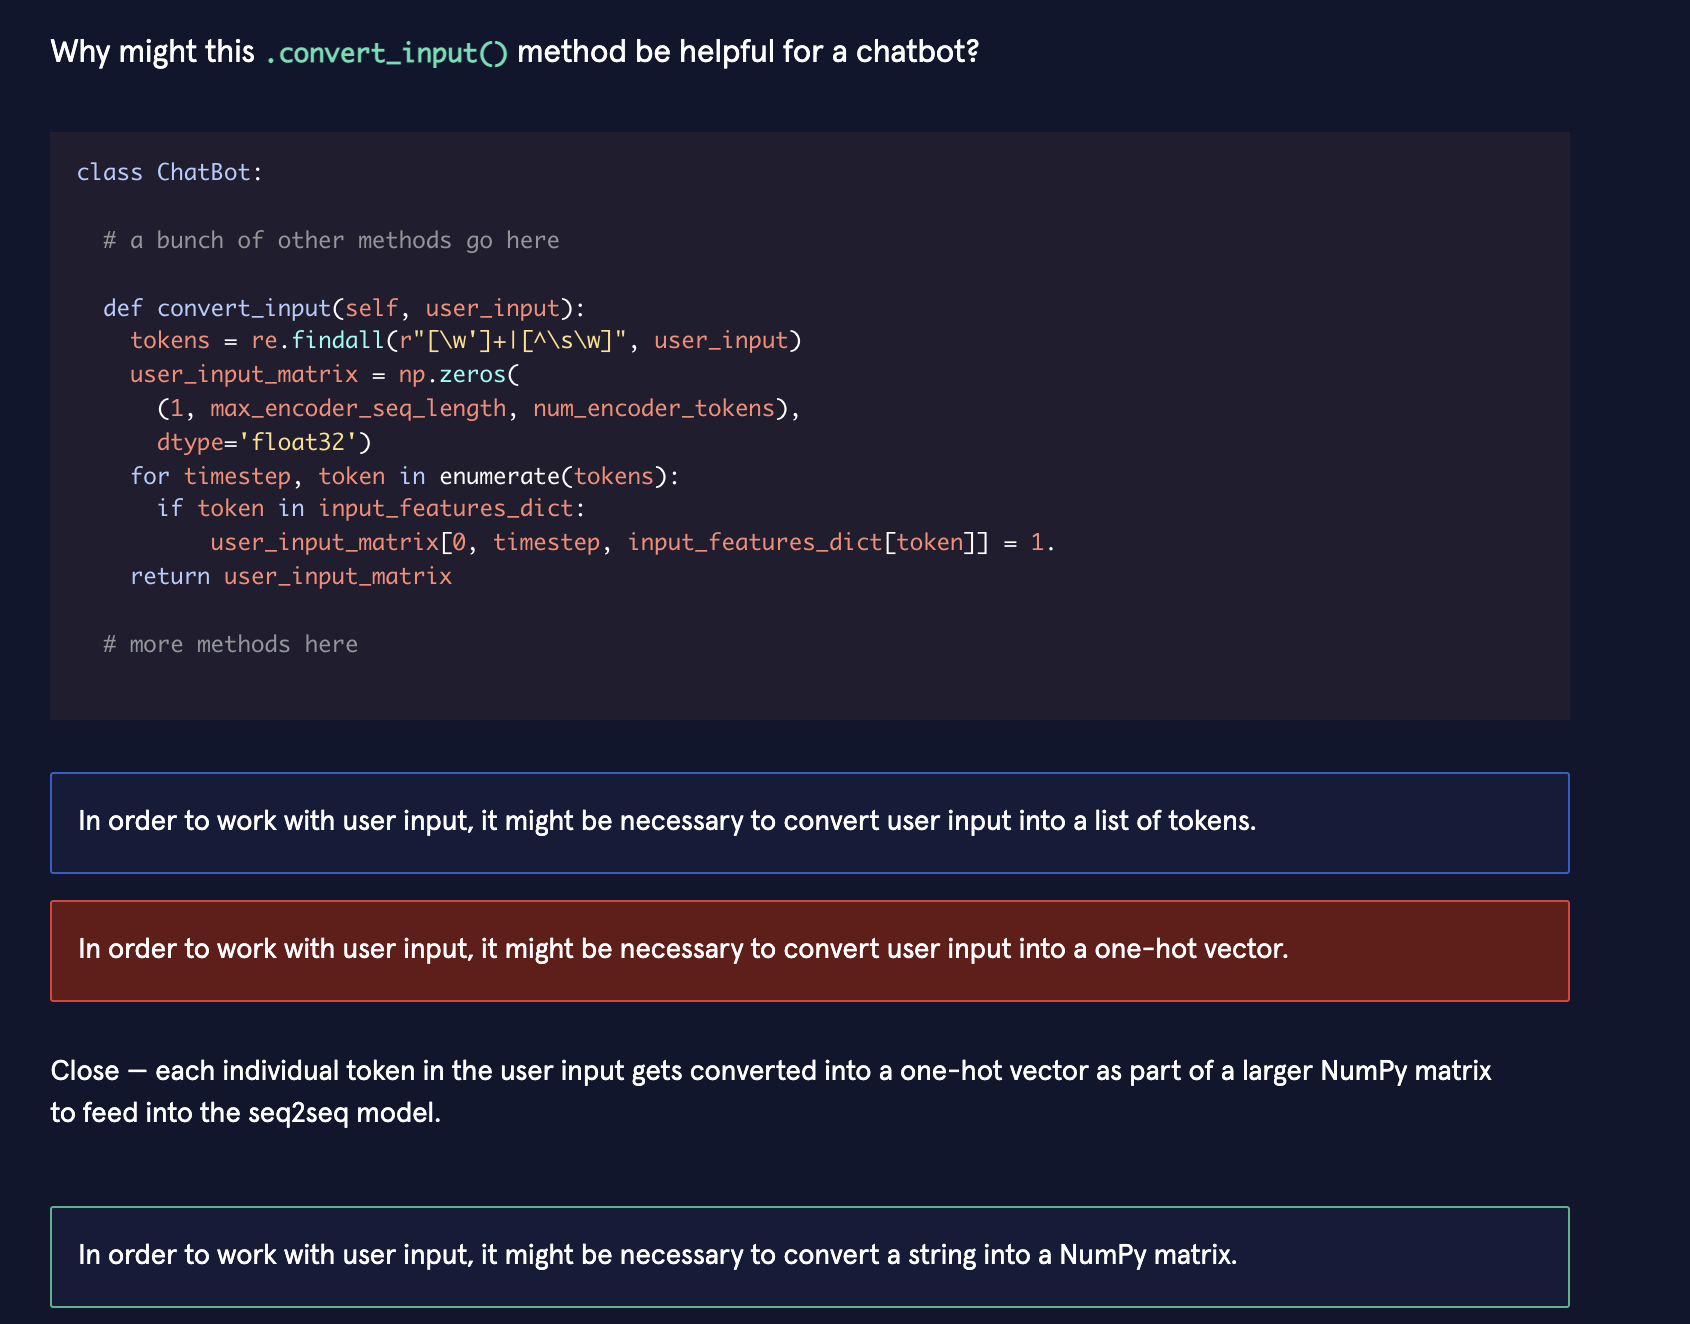

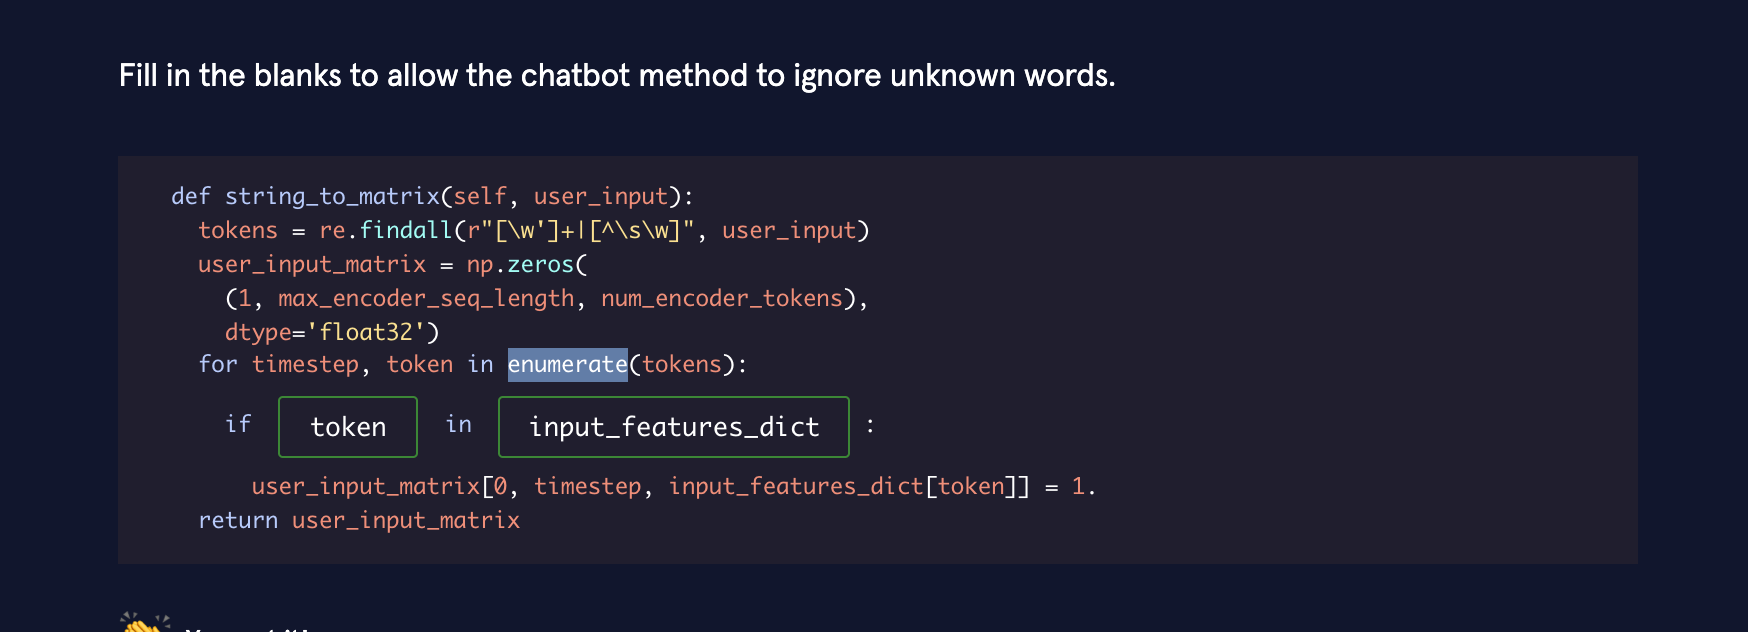

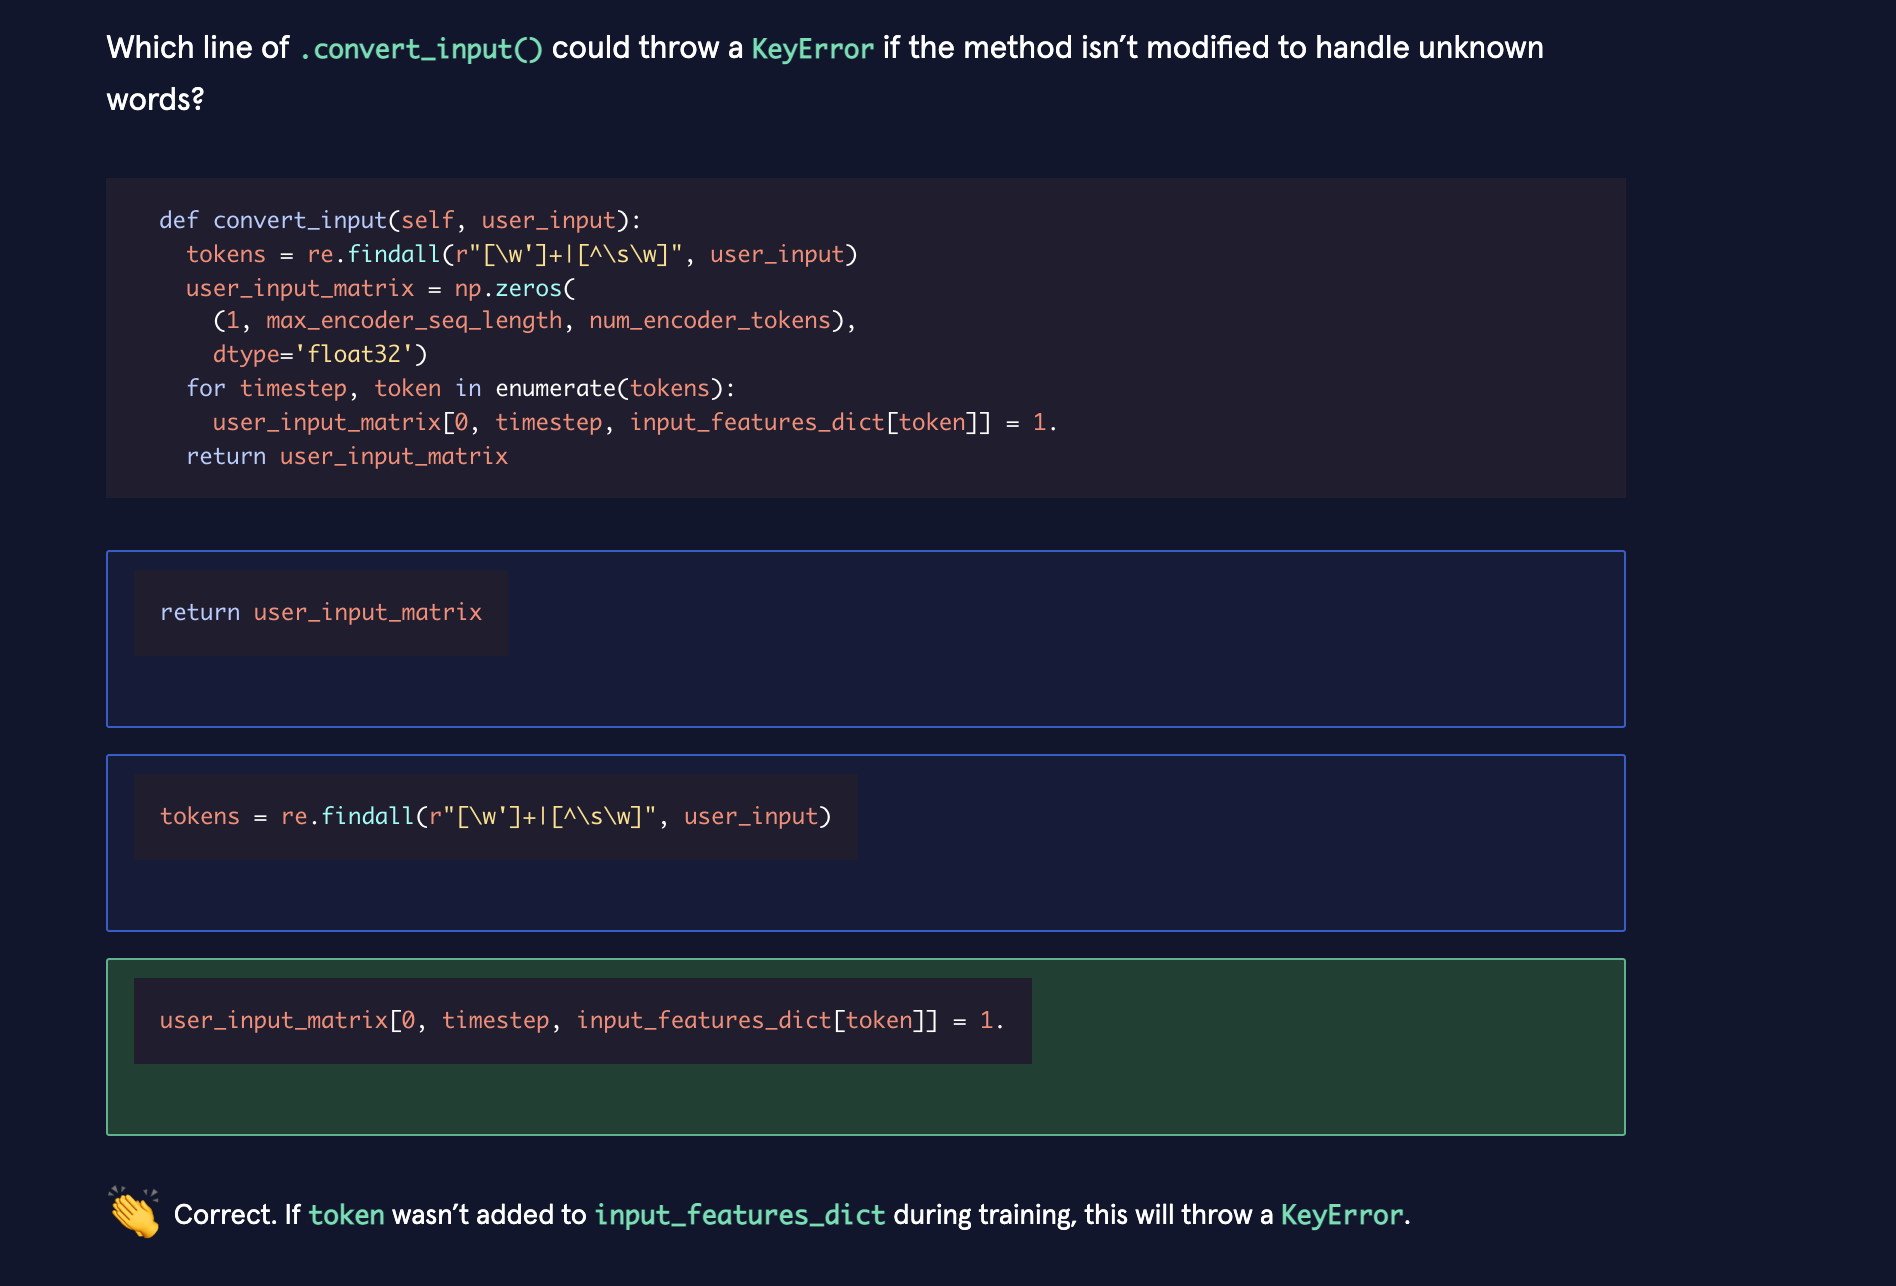

## Off-Platform Project: Generative Chatbot
Apply your deep-learning knowledge and chatbot savvy to build an open-domain generative chatbot.

You’ve trained a chatbot on movie dialog, but what happens when you use real dialog? In this project, you’ll create a generative chatbot using a stream of tweets on a particular topic.

## Setting Up
Installing Python 3
The Codecademy platform lets you run Python easily in our learning environment, but to run/write Python on your own computer you’ll need to install Python on it, if you haven’t already.

This article will walk through installing Python 3 on your computer.

## Installing Tensorflow, Keras, and NumPy
First install Tensorflow. This will be the deep learning back end for Keras.
Now install the Keras API.
To get NumPy, we recommend installing the NumPy package using Anaconda or Miniconda. If you don’t have a package and environment manager, you can also install NumPy through pip:
python -m pip install --user numpy
  
## Set Up The Code
Download and unzip the folder for this project. You should have following files:
https://content.codecademy.com/programs/chatbots/generative-chatbots/twitter-project.zip
twitter_prep.py
preprocessing.py
training_model.py
test_model.py
chat.py
You should also have three .txt files of Twitter data:

love.txt
cat.txt
weather.txt
Take a look at the [your-topic].txt file in a notepad or code editor. You should see tweets related to the topic you picked. If you look closer, you may notice that the tweets are grouped into response pairs; each group of two has an initial tweet and a reply tweet.

## Preprocessing
- Open twitter_prep.py and preprocessing.py in a code editor or IDE.
- In twitter_prep.py, change data_path to the file path of [your-topic].txt. If it’s in the same directory as twitter_prep.py, then all you need is the file name.
- At the bottom of twitter_prep.py, print out all the response pairs from the data. Run the file to see the format they are in. Then comment the print statement out.
- In preprocessing.py, adjust the number of lines of training data you want to work with. We’re giving you a default of 15, but depending on how much you want to tax your computer, you can go up to -1 (the last line of the file).
- Run preprocessing.py and make sure everything works, error-free.

## Training

- Open training_model.py.
- Change the values for the following:
- batch_size: You can choose to adjust this or not at this point. This determines how many response pairs are used at a time for training.
- epochs: This should be a larger number so that the seq2seq model has many chances to improve. Bear in mind that a larger number of epochs will also take your computer a lot longer to process. If you don’t have the ability to leave your computer running awhile for this project, then choose a number that is less than 500.
- Run the code to generate your model. In the terminal, you should see a summary of the model printed out. Meanwhile, you’ll also see a new file in the directory called training_model.h5. This is where your seq2seq training model is saved so that it’s quicker for you to run your code when you instantiate the chatbot.  
  
Note that you may get the following error when attempting to run your program on a regular computer that uses CPU processing:
```
OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.
Abort trap: 6
```
  
  
Below the import statements on training_model.py, there’s a line commented out, which you can uncomment to make the program run. However, if you are concerned about your computer crashing, you may want to hold off completing this project until you have access to a faster computer with GPU processing.

## The Chatbot
Open test_model.py and chat.py. You’ll see that we’ve imported several variables from the preprocessing and training steps of the program and loaded the training model. In chat.py, create a ChatBot class. The Chatbot class should have the following:

- negative_commands: a list of words and phrases that indicate the user’s response is negative when asked if they want to chat.
- exit_commands: a list of words and phrases that should terminate the chatbot conversation.
- .start_chat(): a method that greets the user, asks if the user would like to chat, returns from the program if not (using the negative_commands list), and continues the chat if the user is interested.
- .make_exit(): a method that checks if any exit commands are in the user’s reply. The method should return True if the reply contains any exit command, False if the reply contains no exit commands.
- .string_to_matrix(): a method that accepts user input and creates a NumPy matrix of one-hot vectors with a shape of (1, max_encoder_seq_length, num_encoder_tokens):
```python
tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
user_input_matrix = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
``` 

The method should only account for a given timestep and token if the token exists within the input_features_dict:
```
for timestep, token in enumerate(tokens):
  if token in input_features_dict:
    user_input_matrix[0, timestep, input_features_dict[token]] = 1.
``` 

Finally, the method should return the new matrix.
- .generate_response(): a method that copies the body of decode_sequence() from test_model.py. However, this method should accept user input and use .string_to_matrix() to convert user_input into a NumPy matrix. The method should also remove "<START>" and "<END>" from the chatbot response before it gets returned from the method.
  
At the end of chat.py, test out the chatbot by instantiating a ChatBot object and calling - `.start_chat()` on it. Now run chat.py to see the result and try chatting with your bot.

Congratulations on creating a generative chatbot using real conversational data!

BONUS
Some ways to improve your chatbot:

- Try out different tweet topic files by changing data_path in twitter_prep.py, try using a Twitter scraper to generate more data, or build your own Twitter scraper. Note that the chatbot will generally perform better with shorter tweets and more examples of similar language.
- Tweak the number of lines (response pairs) given to the chatbot for training. Sometimes more is better, sometimes less is better, depending on the dataset. Make sure you re-run training_model.py again to generate a new model before you run chat.py again.
- Try adding more chatbot methods to handle specific intents and entities. Currently, an integrated chatbot usually performs better than a purely generative one.